In [3]:
# import dolfin
from dolfin import *
# import mshr
from mshr import *
import dolfin.common.plotting as fenicsplot
import numpy as np
from matplotlib import pyplot as plt

# simple case in 3D
$$u \times B = f$$

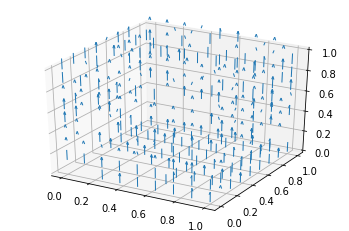

In [4]:
from dolfin import *
# import mshr
from mshr import *
import dolfin.common.plotting as fenicsplot
import numpy as np
from matplotlib import pyplot as plt

# mesh and spaces
res = 8
# mesh = UnitSquareMesh(res, res)
mesh = UnitCubeMesh(res,res,res)
V = VectorFunctionSpace(mesh, 'Lagrange', 1)

u = TrialFunction(V)
v = TestFunction(V)

# BCs
# u_D = Constant((0,0))
u_D = Constant((0,0,1))
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, u_D, boundary)


# equations
f = Constant((1,1,0))
# B = Constant((0,0,1))
B = Expression(("0","0","10*exp(-10*(pow((x[0]-0.5),2)+pow((x[1]-0.5),2)))"),degree=1)
# uxB = as_vector(( u[1]*B[2], -u[0]*B[2] ))
uxB = cross(u,B)
a = inner(uxB,v)*dx
L = dot(f,v)
L = L*dx
u = Function(V)

# solve
solve (a==L, u, bc)

# files
# file_u = File("plots/u.pvd")
# file_u << u

# plot
uvec = np.array(u.vector())
# uvec2D = np.reshape(uvec, (-1, int(np.sqrt(len(uvec)))))
# print(uvec.shape)
# u_magnitude = sqrt(inner(u, u))
# u_magnitude = project(u, V)

plot(u)
plt.show()
# for i in range(40):
#     print(uvec[i])

# Laplace equation in 3D
$$
\Delta u = 0, \quad u : \mathbb{R}^3 \rightarrow \mathbb{R}
$$

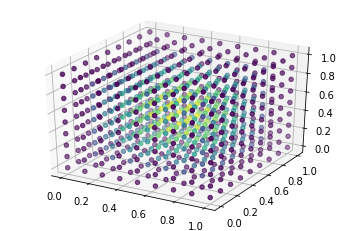

In [6]:
res=8
mesh = UnitCubeMesh(res,res,res)
V = FunctionSpace(mesh, 'Lagrange', 1)
u = TrialFunction(V)
v = TestFunction(V)

# BCs
def boundary(x, on_boundary):
    return on_boundary
bcs = DirichletBC(V,Constant(0.0),boundary)

# equations
a  = inner(grad(u),grad(v))*dx
L = v*dx
u = Function(V)
solve(a == L,u,bcs)

# plot
plot(u)
plt.show()

# time dependence with diffusive term in 3D
$$
\dot u + u \times B + \Delta u = f$$

0
8
16
24
32
40
48
56
64
72


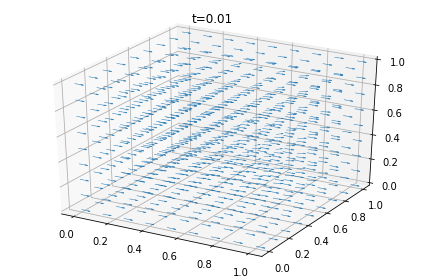

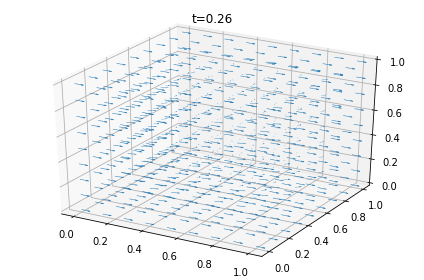

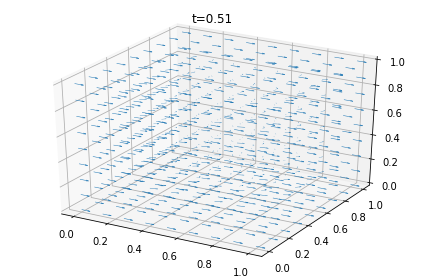

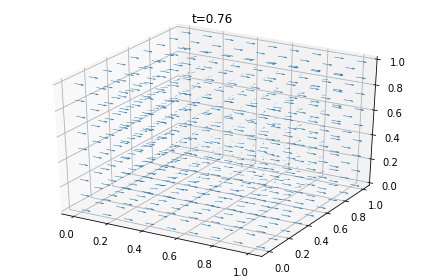

In [49]:
# Time-steps
T = 1
num_steps = 80
dt = T / num_steps

# mesh and spaces
res = 8
# mesh = UnitSquareMesh(res,res)
mesh = UnitCubeMesh(res,res,res)
V = VectorFunctionSpace(mesh, 'Lagrange', 1)
u = TrialFunction(V)
v = TestFunction(V)

# BC
u_D = Constant((0.5,0,0))
# u_D = Constant((0,0))
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, u_D, boundary)

# Lorentz force
B = Expression(("0","0","10*exp(-10*(pow((x[0]-0.5),2)+pow((x[1]-0.9),2)))"),degree=1)
# B = Expression(("0","x[1]-0.5","1*exp(-1*(pow((x[0]-0.5),2)))-0.5"),degree=1)
# B = Expression(("x[2]-0.5","0","1*exp(-1*(pow((x[0]-0.5),2)))-0.5"),degree=1) # fancy B field
uxB = cross(u,B)

# rest of equations
u_n = interpolate(u_D, V)
f = Constant((0.1,0,0))
# g = Expression('0', degree=1)
F = inner(u,v)*dx - inner(u_n + dt*f,v)*dx + 10*dt*dot(uxB,v)*dx + 0.1*dt*inner(grad(u), grad(v))*dx
# F = inner(u,v)*dx - inner(u_n + dt*f,v)*dx + dt*dot(uxB,v)*dx 
a, L = lhs(F), rhs(F) #- g*v*ds 

# time loop
u = Function(V)
t = 0
fignr=1
for n in range(num_steps):
    t += dt
    u_D.t = t
    
    solve(a == L, u, bc)
    
    if n%(num_steps/10)==0:
        print(n)
    
    if n%(num_steps/4)==0:
        plt.figure()
        plot(u)
        plt.title("t="+str(t)[:4])
        plt.tight_layout()
#         plt.savefig("plots/3D-diff_realisticB_"+str(fignr)+".pdf")
        fignr+=1
          
#     # Update previous solution
    u_n.assign(u)

# Navier stokes in 3D
code from here: https://fenicsproject.org/qa/5987/navier-stokes-demo-in-3d/

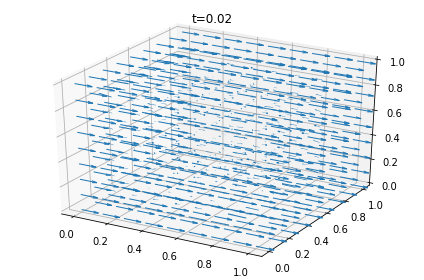

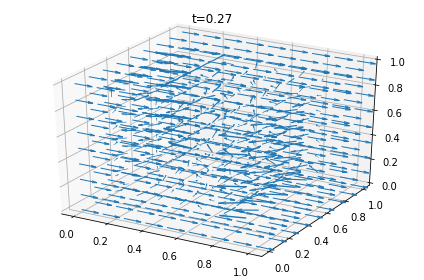

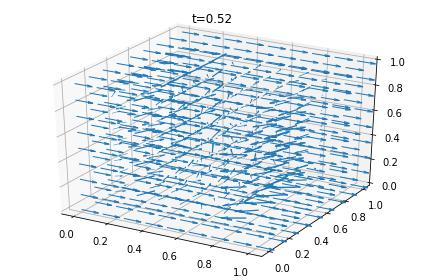

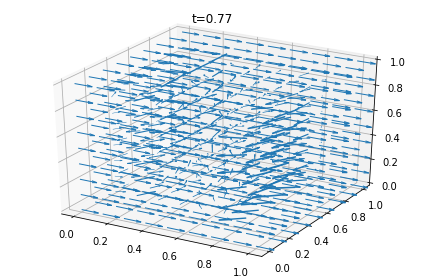

In [52]:
from dolfin import *

# Print log messages only from the root process in parallel
parameters["std_out_all_processes"] = False;

# Load mesh from file
res = 8
mesh = UnitCubeMesh(res,res,res)

class along_xy(SubDomain):

    def inside(self, x, on_boundary):
        # return True if on one of the two left boundaries 
        # AND NOT on one of the two slave edges
        return bool((near(x[0], 0) or near(x[1], 0)) and
        (not ((near(x[0], 1) and near(x[1], 0)) or
        (near(x[0], 0) and near(x[1], 0)))) and on_boundary)

    def map(self, x, y):
       if near(x[0], 1) and near(x[1], 1):
           y[0] = x[0] - 1
           y[1] = x[1] - 1
           y[2] = x[2]
       elif near(x[0], 1):
           y[0] = x[0] - 1
           y[1] = x[1]
           y[2] = x[2]
       elif near(x[1], 1):
           y[0] = x[0]
           y[1] = x[1] - 1
           y[2] = x[2]
       else:
           y[0] = -1000
           y[1] = -1000
           y[2] = -1000

axy = along_xy()

# Define function spaces (P2-P1)
V = VectorFunctionSpace(mesh, "CG", 1, dim=3, constrained_domain=axy)
Q = FunctionSpace(mesh, "CG", 1, constrained_domain=axy)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

# Set parameter values
dt = 0.01
T = 1
nu = 0.01

# Define boundary conditions
noslip  = DirichletBC(V, (1, 0, 0),
                      "on_boundary")

bcu = [noslip]

# Create functions
u0 = Function(V)
u1 = Function(V)
p1 = Function(Q)

# Define coefficients
k = Constant(dt)
f = Expression(('sin(x[0])*cos(x[1])*cos(x[2]) \
              - cos(x[0])*sin(x[1])*cos(x[2])', '0', '0'),degree=1)

f = Expression(('0.01', '0', '0'),degree=1)
# for 2d case 
# f = Expression(('sin(x[0])*cos(x[1])*cos(x[2]) \
#              - cos(x[0])*sin(x[1])*cos(x[2])', '0'))

# B = Expression(("0","x[1]-0.5","10*exp(-1*(pow((x[0]-0.5),2)))-0.5"),degree=1) # kaputt?
B = Expression(("0","0","10*exp(-10*(pow((x[0]-0.5),2)+pow((x[1]-0.5),2)))"),degree=1) # straight
B = Expression(("x[2]-0.5","0","20*exp(-1*(pow((x[0]-0.5),2)))-0.5"),degree=1)# fancy
uxB = cross(u0,B)

# Tentative velocity step
F1 = (1/k)*inner(u - u0, v)*dx + inner(grad(u0)*u0, v)*dx + \
     nu*inner(grad(u), grad(v))*dx - inner(f, v)*dx + inner(uxB,v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Pressure update
a2 = inner(grad(p), grad(q))*dx
L2 = -(1/k)*div(u1)*q*dx

# Velocity update
a3 = inner(u, v)*dx
L3 = inner(u1, v)*dx - k*inner(grad(p1), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Use amg preconditioner if available
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time-stepping
t = dt
fignr=1
n=0
num_steps = T/dt
while t < T + DOLFIN_EPS:

    # Update pressure boundary condition
    #p_in.t = t

    # Compute tentative velocity step
    begin("Computing tentative velocity")
    b1 = assemble(L1)
    [bc.apply(A1, b1) for bc in bcu]
    solve(A1, u1.vector(), b1, "gmres", "default")
    end()

    # Pressure correction
    begin("Computing pressure correction")
    b2 = assemble(L2)
    #[bc.apply(A2, b2) for bc in bcp]
    solve(A2, p1.vector(), b2, "gmres", prec)
    end()

    # Velocity correction
    begin("Computing velocity correction")
    b3 = assemble(L3)
    [bc.apply(A3, b3) for bc in bcu]
    solve(A3, u1.vector(), b3, "gmres", "default")
    end()
    
    # Move to next time step
    u0.assign(u1)
    t += dt
#     if t%(T/10) < 0.00001:
#         print ("t =", t)
    
    # plot
    
#     if t%(T/4) < 0.00001:
    if n%(num_steps/4)==0:
        plt.figure()
        plot(u0)
        plt.title("t="+str(t)[:4])
        plt.tight_layout()
#         plt.savefig("plots2/3Dnavstok_"+str(fignr)+".pdf")
        plt.savefig("plots2/3D-navstok_realisticB_"+str(fignr)+".pdf")
        fignr+=1
        
    n+=1
    
#     if t >= T :
#         plt.figure()
#         plot(u0)
#         for i in range(50):
#             print(np.array(u1.vector())[i])

# 3D Navier stokes - does not work yet, code from FEniCS book

In [80]:
T = 0.1          # final time
num_steps = 100   # number of time steps
dt = T / num_steps # time step size
mu = 0.001         # dynamic viscosity
rho = 1            # density

# mesh and spaces
# channel = Rectangle(Point(0, 0), Point(2, 1))
# cylinder = Circle(Point(0.2, 2.0), 0.5)
# cylinder = Circle(Point(2, 0.5), 0.4)
# domain = channel - cylinder
# mesh = generate_mesh(domain, 10)
res = 8
mesh = UnitCubeMesh(res,res,res)
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

# BC
inflow   = 'near(x[0], 0)'
outflow  = 'near(x[0], 2)'
walls    = 'near(x[1], 0) || near(x[1], 1)'
cylinder = 'on_boundary && x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3'
inflow_profile = ('4.0*1.5*x[1]*(1 - x[1]) / pow(1, 2)', '0')
inflow_profile = ('0.04*1.5*x[1]*(1 - x[1]) / pow(1, 2)', '0')

bcu_inflow = DirichletBC(V, Expression(inflow_profile, degree=2), inflow)
bcu_walls = DirichletBC(V, Constant((0, 0)), walls)
bcu_cylinder = DirichletBC(V, Constant((0, 0)), cylinder)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
bcu = [bcu_inflow, bcu_walls, bcu_cylinder]
bcp = [bcp_outflow]

# Define trial and test functions
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)

# Define expressions used in variational forms
U  = 0.5*(u_n + u)
n  = FacetNormal(mesh)
f  = Constant((0, 0))
k  = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

# Define symmetric gradient
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(len(u))

# lorentz term
# B = Constant((0,0,1))
B = Expression(("0","0","10*exp(-10*(pow((x[0]-1.1),2)+pow((x[1]-0.5),2)))"),degree=1)
B = Expression(("0","0","1"),degree=1)
uxB = as_vector(( u[1]*B[2], -u[0]*B[2] ))

# Define variational problem for step 1
F1 = rho*dot((u - u_n) / k, v)*dx \
   + rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx \
   + 100*dot(uxB,v)*dx 
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx

# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

# files
# file_u = File("plots/u.pvd")

# Time-stepping
t = 0
fignr=1
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1, 'bicgstab', 'hypre_amg')

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2, 'bicgstab', 'hypre_amg')

    # Step 3: Velocity correction step
    b3 = assemble(L3)
#     print("hi1")
    solve(A3, u_.vector(), b3, 'cg', 'sor')
#     print("hi2")
    
    # save solution
#     file_u << u_n

    # Plot solution
    if n%(num_steps/5) == 0:
        plt.figure()
#         plot(mesh)
        plot(u_, title='Velocity, t='+str(t)[:4])
#         plot(p_, title='Pressure')
#         plt.show()
        plt.tight_layout()
#         plt.savefig("plots/plot_NS_"+str(fignr)+".pdf")
        fignr+=1
    
    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to create Dirichlet boundary condition.
*** Reason:  Illegal value dimension (2), expecting (3).
*** Where:   This error was encountered inside DirichletBC.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.2.0.dev0
*** Git changeset:  f0a90b8fffc958ed612484cd3465e59994b695f9
*** -------------------------------------------------------------------------
